In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import time
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
class GRU_RNN_TWO(nn.Module):
        
    def __init__(self,input_size, hidden_size, num_of_layers, num_alpha_embedding, num_beta_embedding, dropout):
        
        super(GRU_RNN_TWO, self).__init__()
        
        self.input_size = input_size
        self.num_alpha_embedding = num_alpha_embedding
        self.num_beta_embedding = num_beta_embedding        
        
        self.hidden_0 = nn.GRU(  
                    input_size=input_size,
                    hidden_size=hidden_size,
                    num_layers=num_of_layers,
                    batch_first=True,
                    dropout=dropout
        )
    

        self.out_alpha = nn.Linear(hidden_size, num_alpha_embedding)
        self.out_beta = nn.Linear(hidden_size, num_beta_embedding)
        
        self.relu_alpha = nn.ReLU()
        self.relu_beta = nn.ReLU()

        self.reg_alpha = nn.Linear(num_alpha_embedding, 1)
        self.reg_beta = nn.Linear(num_beta_embedding, 1)

        
    def forward(self, x):

        # parameters estimation
        output_0, hn_0 = self.hidden_0(x)
        
        output_alpha = self.out_alpha(output_0)
        output_alpha = self.relu_alpha(output_alpha)
        
        output_beta = self.out_beta(output_0)
        output_beta = self.relu_beta(output_beta)
        
        cont_output_alpha = self.reg_alpha(output_alpha)
        cont_output_beta = self.reg_beta(output_beta)
        
        output_dis = [output_alpha, output_beta]
        output_cont = [cont_output_alpha, cont_output_beta]

        return output_dis, output_cont, hn_0
    

In [3]:
class behavior_dataset(Dataset):
    """         
    """
    def __init__(self,dataframe):
        
        # action one hot transformation 
        action = np.array(dataframe['action'])
        if np.all(action == action[0]):
            action = np.append(action,(1-action[0]))
            action = torch.tensor((action).reshape(len(dataframe) + 1),dtype=int)
            action_onehot = nn.functional.one_hot(action, len(action.unique()))
            # delete last one
            action_onehot = action_onehot[:-1]
        else:
            action = torch.tensor((action).reshape(len(dataframe)),dtype=int)
            action_onehot = nn.functional.one_hot(action, len(action.unique()))
        
        # reward
        reward = torch.tensor((np.array(dataframe['reward'])).reshape(len(dataframe)),dtype=int)
        
        # concatinating reward and action
        reward_action = torch.cat([reward[ :, np.newaxis], action_onehot],1)
        
        # adding dummy zeros to the beginning and ignoring the last one
        reward_action_shift = nn.functional.pad(reward_action,[0,0,1,0])[:-1]
        
        # parameters one hot transformation 
        dis_alpha = torch.tensor((np.array(dataframe['alpha_bin'])).reshape(len(dataframe)),dtype=int)
        dis_alpha = dis_alpha.type(dtype=torch.float32)
        
        # parameters one hot transformation 
        dis_beta = torch.tensor((np.array(dataframe['beta_bin'])).reshape(len(dataframe)),dtype=int)
        dis_beta = dis_beta.type(dtype=torch.float32)

        cont_alpha = torch.tensor((np.array(dataframe['alpha'])).reshape(len(dataframe)),dtype=torch.float32)
        cont_beta = torch.tensor((np.array(dataframe['beta'])).reshape(len(dataframe)),dtype=torch.float32)
        
        # network input 
        x = reward_action_shift
        
        n_blocks = int(len(dataframe)/100)
        x.reshape(n_blocks,100,3)[:,0,:] = torch.zeros(size=(n_blocks,3))
        
        # network output 
        y = torch.cat([action_onehot, dis_alpha[ :, np.newaxis],  dis_beta[ :, np.newaxis], 
                                      cont_alpha[ :, np.newaxis], cont_beta[ :, np.newaxis]
                      ],1)
  
        self.x = x.type(dtype=torch.float32)
        self.y = y.type(dtype=torch.float32)
        self.len = len(dataframe)

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
  
    def __len__(self):
        return self.len    
    
class merge_behavior_dataset(Dataset):
    """ 
    Merge Dataset of each agent to one dataset
    
    Args:
        dataset_list: list of Dataset of all agent 
        n_trials: num_of_trials each agent was simulated
        
    Returns: 
        torch Dataset:
        x: [reward_(t-1) , action_(t-1)] all agents
        y: [action_t, parameter embedding] all agents
        
    """
    def __init__(self, dataset_list, n_trials):
        X = []
        Y = []
        for agent in dataset_list:
            for i in range(n_trials):
                X.append(agent[i][0])
                Y.append(agent[i][1])
                
        self.x = torch.stack(X).type(dtype=torch.float32)
        self.y = torch.stack(Y).type(dtype=torch.float32)
        self.len = len(X)   
    
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
  
    def __len__(self):
        return self.len    

In [4]:
def train_model_two(net, train_loader, val_loader ,epochs, name):
        
    min_loss_t = 100
    min_loss_v = 100
        
    # array to track loss 
    train_loss_array , val_loss_array = [], []
    
    # move net to GPU
    net.to(device)

    # Use Adam optimizer
    optimizer = optim.Adam(net.parameters(), lr=0.001) 
    
    # start timer
    start_time = time.time()   
    
    # Loop over epochs 
    for i in range(epochs):        
        # Randomize train batch example 
        train_loader = random.sample(list(train_loader), len(train_loader))
      
        running_loss = 0
        
        run_d_alpha ,run_d_beta = 0,0
        run_c_alpha, run_c_beta  = 0,0 
        # Loop over training batches
        for j, (X, y_true) in enumerate(train_loader):
    
            X, y_true = X.to(device), y_true.to(device) # move to GPU
            X = X.reshape(1,X.shape[0],INPUT_SIZE) # reshape to  1 x trials x input_size
            
            optimizer.zero_grad()  # zero the gradient buffers
            
            y_hat_dis, y_hat_cont, _  = net(X) # forward pass
            
            y_hat_dis_alpha = (y_hat_dis[0].view(-1, num_alpha_embedding)) # Reshape to (SeqLen x Batch, OutputSize)
            y_hat_dis_beta = (y_hat_dis[1].view(-1, num_beta_embedding)) # Reshape to (SeqLen x Batch, OutputSize)

            
            y_hat_dis = [y_hat_dis_alpha,y_hat_dis_beta]
 
            y_hat_cont_alpha = (y_hat_cont[0].view(-1)) # Reshape to (SeqLen x Batch, OutputSize)
            y_hat_cont_beta = (y_hat_cont[1].view(-1)) # Reshape to (SeqLen x Batch, OutputSize)

            
            y_hat_cont = [y_hat_cont_alpha,y_hat_cont_beta]

            loss, l_dis, l_cont = multi_loss(y_hat_dis, y_hat_cont, y_true) # compute loss
                                                                                           

            loss.backward() # backprop the loss
            optimizer.step() # update the weights 
            running_loss += loss.item()
        
            run_d_alpha += l_dis[0].item()
            run_d_beta += l_dis[1].item()
            
            run_c_alpha += l_cont[0].item()
            run_c_beta += l_cont[1].item()

            
        train_loss_array.append(running_loss/len(train_loader))
        loss = eval_net_two(net,val_loader)
        val_loss_array.append(loss)
        

        
        print('================')
        print('loss CE alpha',(run_d_alpha/len(train_loader)))
        print('loss CE beta',(run_d_beta/len(train_loader)))

        
        print('================')
        print('loss mse alpha',(run_c_alpha/len(train_loader)))
        print('loss mse beta',(run_c_beta/len(train_loader)))
    
        
        if train_loss_array[i] <= min_loss_t:
            checkpoint = {'epoch':i+1,'model_state':net.state_dict(),
                          'optim_state':optimizer.state_dict(),'loss':train_loss_array[i]}
            torch.save(checkpoint,f'checkpoint/checkpoint_trnn_train{name}.pth')

            min_loss_t = train_loss_array[i]

        if val_loss_array[i] <= min_loss_v:
            checkpoint = {'epoch':i+1,'model_state':net.state_dict(),
                          'optim_state':optimizer.state_dict(),'loss':val_loss_array[i]}
            torch.save(checkpoint,f'checkpoint/checkpoint_trnn_val{name}.pth')

            min_loss_v = val_loss_array[i]

        print('Step {}, Train Loss {:0.4f}, Val Loss {:0.4f}, Time {:0.1f}s'.format(i+1,
                                                                                    train_loss_array[i],
                                                                                    val_loss_array[i],
                                                                                    time.time() - start_time))

        net.train()

            
    return net, train_loss_array , val_loss_array 

In [5]:
def eval_net_two(net, val_loader):
    
    with torch.no_grad():
        net.eval()
        running_loss = 0
        for j, (X, y_true) in enumerate(val_loader):
            
            X, y_true = X.to(device), y_true.to(device) # move to GPU
            X = X.reshape(1,X.shape[0],INPUT_SIZE) # reshape to  1 x trials x input_size
            
            y_hat_dis, y_hat_cont, _  = net(X) # forward pass
            
            y_hat_dis_alpha = (y_hat_dis[0].view(-1, num_alpha_embedding)) # Reshape to (SeqLen x Batch, OutputSize)
            y_hat_dis_beta = (y_hat_dis[1].view(-1, num_beta_embedding)) # Reshape to (SeqLen x Batch, OutputSize)

            
            y_hat_dis = [y_hat_dis_alpha,y_hat_dis_beta]
 
            y_hat_cont_alpha = (y_hat_cont[0].view(-1)) # Reshape to (SeqLen x Batch, OutputSize)
            y_hat_cont_beta = (y_hat_cont[1].view(-1)) # Reshape to (SeqLen x Batch, OutputSize)

            
            y_hat_cont = [y_hat_cont_alpha,y_hat_cont_beta]

            loss, l_dis, l_cont = multi_loss(y_hat_dis, y_hat_cont, y_true) # compute loss
            
            running_loss += loss.item()
    
    return (running_loss/len(val_loader))
        

In [6]:
path = f'../data/artificial_trainset_2000_alphastat_03.csv' # Maya - changed path
df = pd.read_csv(path)

# define constant 
num_of_action = df['action'].nunique()
num_of_trials = df['trial'].nunique()
num_of_agents = df['agent'].nunique()
num_alpha_embedding = 5 # df['alpha_bin'].nunique()
num_beta_embedding = df['beta_bin'].nunique()

# netowrk input and output dimension  
INPUT_SIZE = 1 + num_of_action


# train val test split 
n_agent_train = int(0.8*num_of_agents)
n_agent_val = int(0.2*num_of_agents)

all_data = []
for i in range(num_of_agents):
    s = i*num_of_trials
    e = (i+1)*num_of_trials
    cur_df = df.iloc[s:e]
    cur_df = cur_df.reset_index()
    all_data.append([i,behavior_dataset(cur_df)])
    
random.shuffle(all_data)
all_data = np.array(all_data, dtype=object)
train_dataset = all_data[:n_agent_train,1]
train_dataset = merge_behavior_dataset(train_dataset,num_of_trials)

val_dataset = all_data[n_agent_train:,1]
val_dataset = merge_behavior_dataset(val_dataset,num_of_trials)
val_agents = np.array([all_data[i,0] for i in range(n_agent_train,num_of_agents)])
    
print('num_of_trials:',num_of_trials)
print('num_of_agents:',num_of_agents)
print('num_alpha_embedding:',num_alpha_embedding)
print('num_beta_embedding:',num_beta_embedding)
print('train_size:', n_agent_train*num_of_trials)
print('train_size:', train_dataset[:][0].shape)
print('val_size:', n_agent_val*num_of_trials)
print('val_size:', val_dataset[:][0].shape)
# print('val_agents',val_agents)

num_of_trials: 1000
num_of_agents: 100
num_alpha_embedding: 5
num_beta_embedding: 5
train_size: 80000
train_size: torch.Size([80000, 3])
val_size: 20000
val_size: torch.Size([20000, 3])


In [7]:
def multi_loss(y_hat_dis, y_hat_cont, y_true):
    
    # slice true parameters embedding 
    y_true_dis_alpha = torch.flatten(y_true[:,2])
    y_true_dis_alpha = y_true_dis_alpha.type(dtype=torch.LongTensor).to(device)
    
    y_true_dis_beta = torch.flatten(y_true[:,3])
    y_true_dis_beta = y_true_dis_beta.type(dtype=torch.LongTensor).to(device)
    
    y_true_cont_alpha =  y_true[:,4]
    y_true_cont_beta =  y_true[:,5]
    
    # define losses
    criterion1 = nn.CrossEntropyLoss()
    criterion2 = nn.MSELoss()
    
    l_dis_alpha = criterion1(y_hat_dis[0], y_true_dis_alpha)
    l_dis_beta = criterion1(y_hat_dis[1], y_true_dis_beta)
    
    l_cont_alpha = criterion2(y_hat_cont[0],y_true_cont_alpha)
    l_cont_beta = criterion2(y_hat_cont[1],y_true_cont_beta)
    
    # combine losses
    total_loss = 0.2*l_dis_alpha  +  0.2*l_dis_beta  + 6*l_cont_alpha  + 0.1*l_cont_beta 
                
    return total_loss, [0.2*l_dis_alpha,  0.2*l_dis_beta ], [6*l_cont_alpha, 0.1*l_cont_beta] 
                                   

In [8]:
aBatch = 1000
aHidden = 32

train_loader = DataLoader(train_dataset,shuffle=False,batch_size=aBatch)
val_loader = DataLoader(val_dataset,shuffle=False,batch_size=aBatch)
rnn = GRU_RNN_TWO(
              input_size=INPUT_SIZE,
              hidden_size=aHidden,
              num_of_layers=1,
              num_alpha_embedding=num_alpha_embedding,
              num_beta_embedding=num_beta_embedding,
              dropout=0.2
             ) 

rnn, loss_train, loss_val = train_model_two(rnn, train_loader, val_loader, 100, '_alphastat_03') 

loss CE alpha 0.23358981683850288
loss CE beta 0.3404260043054819
loss mse alpha 0.8651332062203437
loss mse beta 2.700174264644738
Step 1, Train Loss 4.1393, Val Loss 2.2747, Time 2.8s
loss CE alpha 0.1202891480177641
loss CE beta 0.46569044440984725
loss mse alpha 0.012528051144909114
loss mse beta 1.2432750589214265
Step 2, Train Loss 1.8418, Val Loss 1.3444, Time 4.2s
loss CE alpha 0.08850733749568462
loss CE beta 0.4373720809817314
loss mse alpha 0.007333886052947491
loss mse beta 0.9371952493442223
Step 3, Train Loss 1.4704, Val Loss 1.2686, Time 5.7s
loss CE alpha 0.07186563136056065
loss CE beta 0.3956962700933218
loss mse alpha 0.00651200955035165
loss mse beta 0.9421826816862449
Step 4, Train Loss 1.4163, Val Loss 1.2376, Time 7.1s
loss CE alpha 0.05355476648546755
loss CE beta 0.38693145513534544
loss mse alpha 0.005727427633246407
loss mse beta 0.9341458299895748
Step 5, Train Loss 1.3804, Val Loss 1.2257, Time 8.4s
loss CE alpha 0.03671818536240608
loss CE beta 0.388861492

<Axes: xlabel='Epoch Number', ylabel='Validation Loss'>

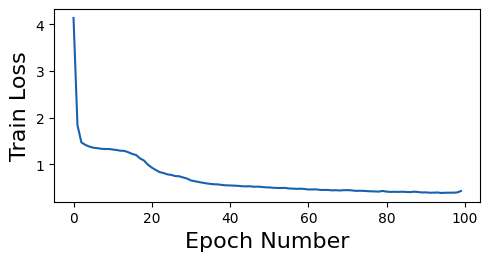

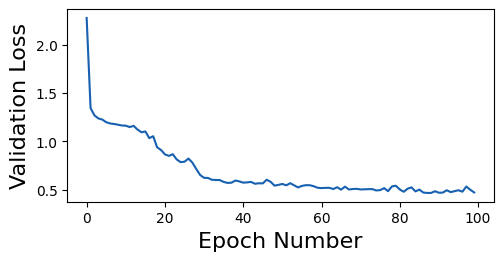

In [9]:
# Plot training and validation loss in each epoch

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize figure
plt.figure(figsize=(5.5, 2.5))
plt.xlabel('Epoch Number', size=16)
plt.ylabel('Train Loss', size=16)

# Line plot for training loss
sns.lineplot(x=np.arange(100), y=loss_train,
                 color='#1761B0')

# Initialize figure
plt.figure(figsize=(5.5, 2.5))
plt.xlabel('Epoch Number', size=16)
plt.ylabel('Validation Loss', size=16)

# Line plot for validation loss
sns.lineplot(x=np.arange(100), y=loss_val,
                 color='#1761B0')